In [53]:
Packages <- c("nleqslv", "broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")
#define my own cv function
cv <- function(x){
    sd(x)/mean(x)
}

#function for 0.99 recruitment
cdf_solve99 <- function (d, theta = theta_eval, k = k_eval) 
{
    return(cdf(d, theta, k) - 0.495)$x
}
#make a mean dispersal distance function that can be applied to a DT rather than for loop method I've used in the past

mean_disp_dist <- function(k, theta){
    
x <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k, theta=theta, , method = "pcubature")$integral)

return(x)

}

In [2]:
#read in the simulation kernel fits
SimKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/SimulationKernelFits.csv")[, data_source := "simulation_08PLD"]
SimKernels15PLD <- fread("~/oceanography/script_output/KernelFits/SimulationKernelFits15DayPLD.csv")[, data_source := "simulation_15PLD"]

#setnames(SimKernels, c("TimeID", "TimeScale"), c("time_id", "time_scale")) #from now on, DTs will be named LikeThis, vectors (including colnames and row ids) will be like_this- until I get around to making that consistent in every script, rename here
#read in the Genetics kernel fits with the same reef metadata structure
GenKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/GeneticKernelFits.csv")

#read in the likelihood surfaces tables
#Geneticss
ProfileGen2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2012NarrowSearch.csv", header = T)
ProfileGen2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2013NarrowSearch.csv", header = T)
ProfileGen2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2014NarrowSearch.csv", header = T)
ProfileGen2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2012_4NarrowSearch.csv", header = T)
ProfileGenNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGeneticNEMNarrowSearch.csv", header = T)
ProfileGenSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGeneticSWMNarrowSearch.csv", header = T)

#ROMS simulations
ProfileSim2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012NarrowSearch.csv", header = T)
ProfileSim2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2013NarrowSearch.csv", header = T)
ProfileSim2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2014NarrowSearch.csv", header = T)
ProfileSim2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012_4NarrowSearch.csv", header = T)
ProfileSimNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalNEMNarrowSearch.csv", header = T)
ProfileSimSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalSWMNarrowSearch.csv", header = T)

#ensure the likelihood surfaces found the same best fit as the bbmle optimization for both simulation and Geneticss
#done
#calculate the 95% likelihood surface cutoffs. Use the log_like from the bbmle function because that's more precise. in the grid search function used for the surfaces, k/theta are limited to 2 decimal places because it's less computation time, but in some cases that means the MLE is from an artificial local optimum that only exists because decimal places are truncated
#genetics
cutoff_Gen2012 <- min(ProfileGen2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012_CI95 <- ProfileGen2012[log_like < cutoff_Gen2012][, `:=`(data_source="genetics", time_id="2012", cutoff=cutoff_Gen2012, best_k=GenKernels[time_id=="2012", k], best_theta=GenKernels[time_id=="2012", theta])]

cutoff_Gen2013 <- min(ProfileGen2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2013_CI95 <- ProfileGen2013[log_like < cutoff_Gen2013][, `:=`(data_source="genetics", time_id="2013", cutoff=cutoff_Gen2013, best_k=GenKernels[time_id=="2013", k], best_theta=GenKernels[time_id=="2013", theta])]

cutoff_Gen2014 <- min(ProfileGen2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2014_CI95 <- ProfileGen2014[log_like < cutoff_Gen2014][, `:=`(data_source="genetics", time_id="2014", cutoff=cutoff_Gen2014, best_k=GenKernels[time_id=="2014", k], best_theta=GenKernels[time_id=="2014", theta])]

cutoff_Gen2012_4 <- min(ProfileGen2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012_4_CI95 <- ProfileGen2012_4[log_like < cutoff_Gen2012_4][, `:=`(data_source="genetics", time_id="2012-4", cutoff=cutoff_Gen2012_4,  best_k=GenKernels[time_id=="2012-4", k], best_theta=GenKernels[time_id=="2012-4", theta])]

cutoff_GenNEM <- min(ProfileGenNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenNEM_CI95 <- ProfileGenNEM[log_like < cutoff_GenNEM][, `:=`(data_source="genetics", time_id="NEM", cutoff=cutoff_GenNEM, best_k=GenKernels[time_id=="NEM", k], best_theta=GenKernels[time_id=="NEM", theta])]

cutoff_GenSWM <- min(ProfileGenSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenSWM_CI95 <- ProfileGenSWM[log_like < cutoff_GenSWM][, `:=`(data_source="genetics", time_id="SWM", cutoff=cutoff_GenSWM, best_k=GenKernels[time_id=="SWM", k], best_theta=GenKernels[time_id=="SWM", theta])]

#biophysical simulation
cutoff_Sim2012 <- min(ProfileSim2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012_CI95 <- ProfileSim2012[log_like < cutoff_Sim2012][, `:=`(data_source="simulation_08PLD", time_id="2012", cutoff=cutoff_Sim2012, best_k=SimKernels[time_id=="2012", k], best_theta=SimKernels[time_id=="2012", theta])]

cutoff_Sim2013 <- min(ProfileSim2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2013_CI95 <- ProfileSim2013[log_like < cutoff_Sim2013][, `:=`(data_source="simulation_08PLD", time_id="2013", cutoff=cutoff_Sim2013, best_k=SimKernels[time_id=="2013", k], best_theta=SimKernels[time_id=="2013", theta])]

cutoff_Sim2014 <- min(ProfileSim2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2014_CI95 <- ProfileSim2014[log_like < cutoff_Sim2014][, `:=`(data_source="simulation_08PLD", time_id="2014", cutoff=cutoff_Sim2014,  best_k=SimKernels[time_id=="2014", k], best_theta=SimKernels[time_id=="2014", theta])]

cutoff_Sim2012_4 <- min(ProfileSim2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012_4_CI95 <- ProfileSim2012_4[log_like < cutoff_Sim2012_4][, `:=`(data_source="simulation_08PLD", time_id="2012-4", cutoff=cutoff_Sim2012_4,  best_k=SimKernels[time_id=="2012-4", k], best_theta=SimKernels[time_id=="2012-4", theta])]

cutoff_SimNEM <- min(ProfileSimNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSimNEM_CI95 <- ProfileSimNEM[log_like < cutoff_SimNEM][, `:=`(data_source="simulation_08PLD", time_id="NEM", cutoff=cutoff_SimNEM,  best_k=SimKernels[time_id=="NEM", k], best_theta=SimKernels[time_id=="NEM", theta])]

cutoff_SimSWM <- min(ProfileSimSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSimSWM_CI95 <- ProfileSimSWM[log_like < cutoff_SimSWM][, `:=`(data_source="simulation_08PLD", time_id="SWM", cutoff=cutoff_SimSWM,  best_k=SimKernels[time_id=="SWM", k], best_theta=SimKernels[time_id=="SWM", theta])]



In [3]:
##combine into one table for plotting, maybe move to later after getting upper and lower profiles
GenPlusSimKernels95CI <- rbindlist(list(ProfileGen2012_CI95, ProfileGen2013_CI95, ProfileGen2013_CI95, ProfileGen2014_CI95, ProfileGen2012_4_CI95, ProfileGenNEM_CI95, ProfileGenSWM_CI95,
             ProfileSim2012_CI95, ProfileSim2013_CI95, ProfileSim2014_CI95, ProfileSim2012_4_CI95, ProfileSimNEM_CI95, ProfileSimSWM_CI95))#[ 
    #, `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
    #                        med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
    #                        dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
    #                  by=c("k_eval", "theta_eval")]
#fwrite(GenPlusSimKernels95CI, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CI.csv")

In [4]:
##add in the 15 day PLD kernels
##ROMS simulations
#Profile_15PLDSim2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012NarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSim2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2013NarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSim2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2014NarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSim2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012_4NarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSimNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalNEMNarrowSearch15DayPLD.csv", header = T)
#Profile_15PLDSimSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalSWMNarrowSearch15DayPLD.csv", header = T)
#
##biophysical simulation
#cutoff_15PLDSim2012 <- min(Profile_15PLDSim2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSim2012_CI95 <- Profile_15PLDSim2012[log_like < cutoff_15PLDSim2012][, `:=`(data_source="simulation_15PLD", time_id="2012", cutoff=cutoff_15PLDSim2012, best_k=SimKernels15PLD[time_id=="2012", k], best_theta=SimKernels15PLD[time_id=="2012", theta])]
#
#cutoff_15PLDSim2013 <- min(Profile_15PLDSim2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSim2013_CI95 <- Profile_15PLDSim2013[log_like < cutoff_15PLDSim2013][, `:=`(data_source="simulation_15PLD", time_id="2013", cutoff=cutoff_15PLDSim2013, best_k=SimKernels15PLD[time_id=="2013", k], best_theta=SimKernels15PLD[time_id=="2013", theta])]
#
#cutoff_15PLDSim2014 <- min(Profile_15PLDSim2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSim2014_CI95 <- Profile_15PLDSim2014[log_like < cutoff_15PLDSim2014][, `:=`(data_source="simulation_15PLD", time_id="2014", cutoff=cutoff_15PLDSim2014,  best_k=SimKernels15PLD[time_id=="2014", k], best_theta=SimKernels15PLD[time_id=="2014", theta])]
#
#cutoff_15PLDSim2012_4 <- min(Profile_15PLDSim2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSim2012_4_CI95 <- Profile_15PLDSim2012_4[log_like < cutoff_15PLDSim2012_4][, `:=`(data_source="simulation_15PLD", time_id="2012-4", cutoff=cutoff_15PLDSim2012_4,  best_k=SimKernels15PLD[time_id=="2012-4", k], best_theta=SimKernels15PLD[time_id=="2012-4", theta])]
#
#cutoff_15PLDSimNEM <- min(Profile_15PLDSimNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSimNEM_CI95 <- Profile_15PLDSimNEM[log_like < cutoff_15PLDSimNEM][, `:=`(data_source="simulation_15PLD", time_id="NEM", cutoff=cutoff_15PLDSimNEM,  best_k=SimKernels15PLD[time_id=="NEM", k], best_theta=SimKernels15PLD[time_id=="NEM", theta])]
#
#cutoff_15PLDSimSWM <- min(Profile_15PLDSimSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##pull out the values above the cutoff
#Profile_15PLDSimSWM_CI95 <- Profile_15PLDSimSWM[log_like < cutoff_15PLDSimSWM][, `:=`(data_source="simulation_15PLD", time_id="SWM", cutoff=cutoff_15PLDSimSWM,  best_k=SimKernels15PLD[time_id=="SWM", k], best_theta=SimKernels15PLD[time_id=="SWM", theta])]
#
#GenPlusSimKernels95CI <- rbindlist(list(GenPlusSimKernels95CI,
#             Profile_15PLDSim2012_CI95, Profile_15PLDSim2013_CI95, Profile_15PLDSim2014_CI95, Profile_15PLDSim2012_4_CI95, Profile_15PLDSimNEM_CI95, Profile_15PLDSimSWM_CI95))
#
#fwrite(GenPlusSimKernels95CI, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CIBothPLDOptions.csv")
GenPlusSimKernels95CI[, .N, by=.(time_id, data_source)]

time_id,data_source,N
2012,genetics,231068
2013,genetics,979990
2014,genetics,139241
2012-4,genetics,17230
NEM,genetics,68908
SWM,genetics,505126
2012,simulation_08PLD,985675
2013,simulation_08PLD,149845
2014,simulation_08PLD,153607
2012-4,simulation_08PLD,149923


In [6]:
#calculate various summary stats that we will plot for 100 kernels in the CI of each time frame
GenPlusSimKernels95CISamp <- GenPlusSimKernels95CI[, .SD[sample(.N, 100, prob=max(log_like)/log_like)], by = c("time_id", "data_source")][ #weight the fits by distance from the best log like
    , `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
                            med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
                            dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
                      by=c("k_eval", "theta_eval")]

#write out table with summary stats that are plotted to keep plots consistent
#fwrite(GenPlusSimKernels95CISamp, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CISummaryStatsSampForPlots.csv")

In [ ]:
cubintegrate(integrate_kernel_sum0.5, k=-.89, theta=.56, 0, 30, method = "pcubature")$integral
cubintegrate(integrate_kernel_sum0.5, k=-2.6, theta=1.58, 0, 30, method = "pcubature")$integral

In [65]:
GenPlusSimKernels95CILower <- GenPlusSimKernels95CI[k_eval <= best_k & theta_eval <= best_theta, .(lower_k=k_eval, lower_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "lower"][
    log_like ==max_log_like, .(lower_k, lower_theta), by=.(time_id, data_source)]

GenPlusSimKernels95CIUpper <- GenPlusSimKernels95CI[k_eval >= best_k & theta_eval >= best_theta][, .(upper_k=k_eval, upper_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "upper"][
    log_like ==max_log_like, .(upper_k, upper_theta), by=.(time_id, data_source)]

GenPlusSimKernels95CISummary <- unique(GenPlusSimKernels95CILower[GenPlusSimKernels95CIUpper, on=.(time_id, data_source)], by= c("time_id", "data_source"))

GenSummary <- GenPlusSimKernels95CISummary[GenKernels, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 3))][]  
SimSummary <- GenPlusSimKernels95CISummary[SimKernels, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 3))][]    
#SimSummary15PLD <- GenPlusSimKernels95CISummary[SimKernels15PLD, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 3))][]    

SimSummary[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI
#SimSummary15PLD[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI
GenSummary[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI

KernelFittingSummary <- rbindlist(list(SimSummary, GenSummary))[, -"log_like"]# SimSummary15PLD,
KernelFittingSummary[, `:=`(upper_mdd=round(mean_disp_dist(k = lower_k, theta=lower_theta), 2),
                            lower_mdd=round(mean_disp_dist(k = upper_k, theta=upper_theta), 2),
                            upper_med=round(nleqslv(x = 7, fn = cdf_solve, k=lower_k, theta=lower_theta)$x, 2),
                            lower_med=round(nleqslv(x = 7, fn = cdf_solve, k=upper_k, theta=upper_theta)$x, 2),
                            upper_prop1=round(cubintegrate(integrate_kernel_sum0.5, k=lower_k, theta=lower_theta, 0, 1, method = "pcubature")$integral*2, 3),
                            prop1=round(cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, 0, 1, method = "pcubature")$integral*2, 3),
                            lower_prop1=round(cubintegrate(integrate_kernel_sum0.5, k=upper_k, theta=upper_theta, 0, 1, method = "pcubature")$integral*2, 3),
                            upper_prop30=round(cubintegrate(integrate_kernel_sum0.5, k=lower_k, theta=lower_theta, 0, 30, method = "pcubature")$integral*2, 3),
                            prop30=round(cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, 0, 30, method = "pcubature")$integral*2, 3),
                            lower_prop30=round(cubintegrate(integrate_kernel_sum0.5, k=upper_k, theta=upper_theta, 0, 30, method = "pcubature")$integral*2, 3),
                            upper_dist99=round(nleqslv(x = 7, fn = cdf_solve99, k=lower_k, theta=lower_theta)$x, 2),
                            dist99=round(nleqslv(x = 7, fn = cdf_solve99, k=k, theta=theta)$x, 2),
                            lower_dist99=round(nleqslv(x = 7, fn = cdf_solve99, k=upper_k, theta=upper_theta)$x, 2),
                            upper_dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=lower_k, theta=lower_theta)$x, 2),
                            lower_dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=upper_k, theta=upper_theta)$x, 2)),
                      by=c("time_id", "data_source")]
setcolorder(KernelFittingSummary, c("data_source", "time_scale", "time_id", "lower_k", "k", "upper_k", "lower_theta", "theta", "upper_theta", "lower_mdd", "mdd", "upper_mdd", "lower_med", "med", "upper_med","lower_prop1", "prop1", "upper_prop1","lower_prop30", "prop30", "upper_prop30", "lower_dist90", "dist90", "upper_dist90","lower_dist99", "dist99", "upper_dist99")) 
KernelFittingSummary
#fwrite(KernelFittingSummary, "~/oceanography/script_output/KernelFits/summary_tables/KernelFittingSummary.csv")

time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like


time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like


data_source,time_scale,time_id,lower_k,k,upper_k,lower_theta,theta,upper_theta,lower_mdd,...,upper_prop1,lower_prop30,prop30,upper_prop30,lower_dist90,dist90,upper_dist90,lower_dist99,dist99,upper_dist99
simulation_08PLD,annual,2012,-2.167,-2.164,-2.162,4.980,4.991,4.995,4.20,...,0.125,1.000,1.000,1.000,7.86,7.88,7.90,10.18,10.20,10.24
simulation_08PLD,annual,2013,-0.463,-0.461,-0.459,0.629,0.630,0.630,4.19,...,0.286,0.994,0.994,0.994,10.34,10.38,10.43,26.10,26.15,26.36
simulation_08PLD,annual,2014,0.280,0.283,0.285,0.527,0.528,0.528,3.63,...,0.354,0.994,0.994,0.994,9.10,9.16,9.22,25.59,25.64,25.95
simulation_08PLD,interannual,2012-4,-0.105,-0.104,-0.103,0.576,0.576,0.576,3.90,...,0.321,0.994,0.994,0.994,9.72,9.72,9.74,25.87,25.90,25.92
simulation_08PLD,season,NEM,-0.226,-0.225,-0.225,0.607,0.607,0.608,3.70,...,0.321,0.996,0.996,0.996,9.15,9.19,9.21,23.59,23.74,23.77
simulation_08PLD,season,SWM,0.601,0.602,0.605,0.416,0.416,0.417,7.81,...,0.256,0.948,0.946,0.946,19.82,20.02,20.17,65.53,66.71,66.78
genetics,annual,2012,-3.494,-3.271,-3.200,1.940,3.529,4.337,11.93,...,0.034,0.991,0.965,0.797,22.56,25.08,38.95,29.87,34.43,61.52
genetics,annual,2013,-3.289,-3.275,-3.191,4.372,5.000,5.000,11.75,...,0.041,0.996,0.985,0.975,21.99,23.91,24.63,28.47,30.97,32.57
genetics,annual,2014,1.861,1.972,2.506,0.215,0.260,0.268,32.82,...,0.029,0.761,0.606,0.255,79.38,182.37,1872.89,379.48,903.20,11165.12
genetics,interannual,2012-4,-0.469,-0.226,-0.116,0.434,0.439,0.453,10.50,...,0.134,0.917,0.878,0.824,26.62,34.74,46.95,82.92,110.61,150.78


In [77]:
#reformat summary table for publication
KernelFittingSummaryPub <- KernelFittingSummary[data_source != "simulation_15PLD"][, .(k=paste(lower_k, k, upper_k),
                                                                                         theta=paste(lower_theta, theta, upper_theta),
                                                                                         mdd=paste(lower_mdd, mdd, upper_mdd),
                                                                                        prop1=paste(lower_prop1, prop1, upper_prop1),
                                                                                         prop30=paste(lower_prop30, prop30, upper_prop30),
                                                                                         dist90=paste(lower_dist90, dist90, upper_dist90),
                                                                                      dist99=paste(lower_dist99, dist99, upper_dist99)), by=c("data_source", "time_id")]
#fwrite(KernelFittingSummaryPub, "~/oceanography/script_output/KernelFits/summary_tables/KernelFittingSummaryPublication.csv")

In [140]:
cor.test(KernelFittingSummary[data_source=="simulation_08PLD" & time_scale=="annual", mdd], KernelFittingSummary[data_source=="genetics" & time_scale=="annual", mdd], method="spearman" )


Warning message in cor.test.default(KernelFittingSummary[data_source == "simulation_08PLD" & :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  KernelFittingSummary[data_source == "simulation_08PLD" & time_scale ==  and KernelFittingSummary[data_source == "genetics" & time_scale ==     "annual", mdd] and     "annual", mdd]
S = 7.4641, p-value = 0.3333
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.8660254 


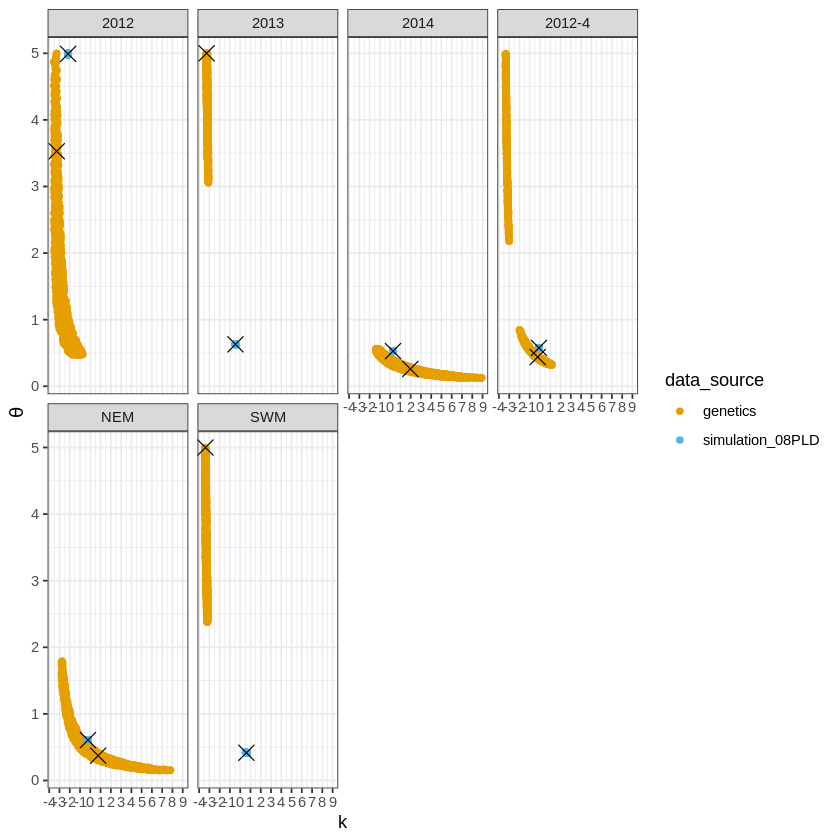

In [135]:
GenPlusSimKernels95CI$time_id <- factor(GenPlusSimKernels95CI$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
KernelFittingSummary$time_id <- factor(KernelFittingSummary$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
#PubKernels$time_id <- factor(PubKernels$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
GenPlusSimKernels95CI$data_source <- factor(GenPlusSimKernels95CI$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))
KernelFittingSummary$data_source <- factor(KernelFittingSummary$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

surface <- ggplot() +
        geom_point(data=GenPlusSimKernels95CI[data_source != "simulation_15PLD"][, .SD[sample(.N, 1000, prob=max(log_like)/log_like)], by = c("time_id", "data_source")], aes(x=k_eval, y=theta_eval, color=data_source, fill=data_source)) +
        geom_point(data=KernelFittingSummary[data_source != "simulation_15PLD"], aes(x=k, y=theta),shape=4, size=4) + #, color=data_source, fill=data_source
        #geom_point(data=PubKernels, aes(x=best_k, y=best_theta),shape=8, size=4) + #, color=data_source, fill=data_source
        scale_x_continuous(breaks = seq(-10, 10, by = 1)) + #, expand = c(0, 0)
        scale_y_continuous(breaks = seq(0, 6, by = 1)) +#, expand = c(0, 0)
        theme(axis.text.x = element_text(size=12, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
        axis.text.y =  element_text(size=12, color="black", family="Helvetica"),
        axis.title.y =  element_text(size=14, color="black", family="Helvetica"), 
        axis.title.x =  element_text(size=14, color="black", family="Helvetica")) +
        xlab("k") + ylab(expression(theta)) +
        theme_bw() + 
        scale_colour_manual(values=cbbPalette)+
        scale_fill_manual(values=cbbPalette)+
        facet_wrap(~ time_id, ncol = 4) 
#surface_grid <- surface +facet_grid(cols=vars(time_id), fig.width=6)
surface
#ggsave(filename="SurfaceGrid.png",  plot=surface, path="~/oceanography/script_output/plots/", units="in", width=8, height=6)


In [126]:
#read in sampled kernels for plotting KERNELS
GenPlusSimKernels95CISamp <- fread("~/oceanography/script_output/KernelFits/GenPlusSimKernels95CISummaryStatsSampForPlots.csv")

In [ ]:
#plot the actual dispersal kernels

In [127]:
#make a df with the pdf values at each distance to plot for each kernel fit, use 200 kernel fits not 1000

ToPlot <- cbind(data.table(dist_eval=rep(seq(0, 80, 0.1), nrow(GenPlusSimKernels95CISamp))), #each time_id/data_source combo will need a row for each distance to evaluate, so make that for distances
              do.call("rbind", replicate(length(seq(0, 80, 0.1)), GenPlusSimKernels95CISamp[, .(time_id, data_source, k_eval, theta_eval, group=.I)], simplify = FALSE))) #add the group number for plotting

nrow(ToPlot)==nrow(GenPlusSimKernels95CISamp)*length(seq(0, 80, 0.1)) #should be true

#add a column for pdf value at that distance

ToPlot[, pdf := predicted_disp(k=k_eval, theta=theta_eval, d=dist_eval),
                      by=c("k_eval", "theta_eval", "dist_eval")]
BestFits <- cbind(data.table(dist_eval=rep(seq(0, 80, 0.1), nrow(KernelFittingSummary))), #each time_id/data_source combo will need a row for each distance to evaluate, so make that for distances
            do.call("rbind", replicate(length(seq(0, 80, 0.1)), KernelFittingSummary[, .(time_id, data_source, k, theta, group=.I)], simplify = FALSE)))[ #add the group number for plotting
            , pdf := predicted_disp(k=k, theta=theta, d=dist_eval),
                      by=c("k", "theta", "dist_eval")]


[1] TRUE

In [128]:
 head(ToPlot)

dist_eval,time_id,data_source,k_eval,theta_eval,group,pdf
0.0,2012,genetics,-2.924877,1.3682138,1,0.05866663
0.1,2012,genetics,-3.151503,1.7949487,2,0.04810539
0.2,2012,genetics,-1.502795,0.6236976,3,0.13448996
0.3,2012,genetics,-3.050938,2.8118488,4,0.05312658
0.4,2012,genetics,-3.480112,3.5382061,5,0.03421647
0.5,2012,genetics,-3.378130,1.4408495,6,0.03748081


Warning message:
“Removed 7218 row(s) containing missing values (geom_path).”Warning message:
“Removed 81 row(s) containing missing values (geom_path).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 7218 row(s) containing missing values (geom_path).”Warning message:
“Removed 81 row(s) containing missing values (geom_path).”

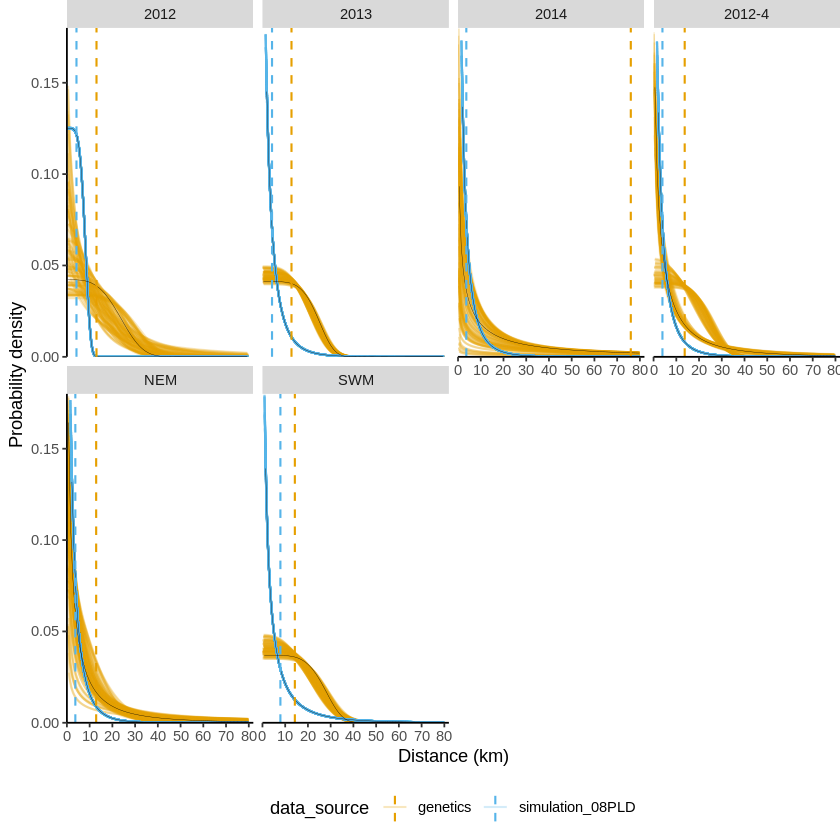

In [131]:
ToPlot$time_id <- factor(ToPlot$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
BestFits$time_id <- factor(BestFits$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
KernelFittingSummary$time_id <- factor(KernelFittingSummary$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
#PubBestFits$time_id <- factor(PubBestFits$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))

#fix the levels for data source so colors are consistent between graphs
ToPlot$data_source <- factor(ToPlot$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))
BestFits$data_source <- factor(BestFits$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))
KernelFittingSummary$data_source <- factor(KernelFittingSummary$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

kernels <- ggplot() + 
    geom_line(data= ToPlot[data_source != "simulation_15PLD"], aes(x=dist_eval, y=pdf, color=data_source, group=group), size=.6, alpha=0.25)+
    geom_line(data=BestFits[data_source != "simulation_15PLD"], aes(x=dist_eval, y=pdf, group=group), color="black", size=0.1) +
    #geom_line(data=BestFits, aes(x=dist_eval, y=pdf, color=data_source, group=group), size=0.3) + #for pub kernels plot
    #geom_line(data=PubBestFits, aes(x=dist_eval, y=pdf, group=group), color="black", size=0.3) +  #for pub kernels plot
      #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    #annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2014", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    geom_vline(data=KernelFittingSummary[data_source != "simulation_15PLD"], aes(xintercept = mdd, color = data_source), linetype="dashed", size=0.6) + 
    #geom_vline(data=KernelFittingSummary[data_source=="simulation"], aes(xintercept = mdd), linetype="dashed", color = "#5ab4ac", size=0.6) +
    #geom_vline(data=PubKernels, aes(xintercept = mdd), linetype="dashed", color = "black", size=0.6) +  #for pub kernels plot
    theme(legend.position = "bottom",
    legend.key=element_blank(),
    #axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
    plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,82), expand = c(0, 0), breaks=c(seq(0, 80, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) + 
    #scale_colour_manual(name = "data_source",values = c("#CC6677","#5ab4ac"))+
        scale_colour_manual(values=cbbPalette)+
        scale_fill_manual(values=cbbPalette)+
        facet_wrap(~ time_id, ncol = 4) 
kernels
#Facet <- test + facet_grid(.~time_id) +
#  theme(aspect.ratio = 1) #+ ggtitle("2014 Simulations, red line genetics")
#Facet

#ggsave(filename="GenPlusSimKernels.png", plot= kernels, path="~/oceanography/script_output/plots/" )


In [49]:
KernelFittingSummaryPub


data_source,time_id,k,theta,mdd,prop30,dist90
simulation_08PLD,2012,-2.167 -2.164 -2.162,4.98 4.991 4.995,4.2 4.21 4.22,0.5 0.5 0.5,7.86 7.88 7.9
simulation_08PLD,2013,-0.463 -0.461 -0.459,0.629 0.63 0.63,4.19 4.21 4.23,0.497 0.497 0.497,10.34 10.38 10.43
simulation_08PLD,2014,0.28 0.283 0.285,0.527 0.528 0.528,3.63 3.65 3.67,0.497 0.497 0.497,9.1 9.16 9.22
simulation_08PLD,2012-4,-0.105 -0.104 -0.103,0.576 0.576 0.576,3.9 3.9 3.91,0.497 0.497 0.497,9.72 9.72 9.74
simulation_08PLD,NEM,-0.226 -0.225 -0.225,0.607 0.607 0.608,3.7 3.71 3.72,0.498 0.498 0.498,9.15 9.19 9.21
simulation_08PLD,SWM,0.601 0.602 0.605,0.416 0.416 0.417,7.81 7.89 7.94,0.474 0.473 0.473,19.82 20.02 20.17
genetics,2012,-3.494 -3.271 -3.2,1.94 3.529 4.337,11.93 13.02 18.81,0.495 0.482 0.398,22.56 25.08 38.95
genetics,2013,-3.289 -3.275 -3.191,4.372 5 5,11.75 12.77 13.03,0.498 0.492 0.488,21.99 23.91 24.63
genetics,2014,1.861 1.972 2.506,0.215 0.26 0.268,32.82 76 836.81,0.38 0.303 0.127,79.38 182.37 1872.89
genetics,2012-4,-0.469 -0.226 -0.116,0.434 0.439 0.453,10.5 13.69 18.5,0.458 0.439 0.412,26.62 34.74 46.95


In [72]:
#plot the variation (CV) to see if the scale of variation matches genetics and simulations
MLEVariation <- KernelFittingSummary[time_scale != "interannual",.( cv_theta=round(cv(theta),2), cv_mdd=round(cv(mdd),2), cv_prop1=round(cv(prop1),3), cv_prop30=round(cv(prop30),3), cv_dist99=round(cv(dist99),2)), by=c("data_source", "time_scale")]   
MLEVariation

#fwrite(MLEVariation, "~/oceanography/script_output/KernelFits/VariationSummary.csv")

data_source,time_scale,cv_theta,cv_mdd,cv_prop1,cv_prop30,cv_dist99
simulation_08PLD,annual,1.24,0.08,0.463,0.003,0.44
simulation_08PLD,season,0.26,0.51,0.157,0.036,0.67
genetics,annual,0.83,1.07,0.579,0.250,1.56
genetics,season,1.22,0.07,0.987,0.050,0.77


In [68]:
#get a distribution of CV for bootstrapped biophysical kernels

BootBioPhys <- rbind(fread("~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels08DayPLD.csv")[, data_source := "simulation_08PLD"],
fread("~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels15DayPLD.csv")[, data_source := "simulation_15PLD"])[
    , prop1 :=round(cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, 0, 1, method = "pcubature")$integral*2, 3)][
     , prop30 :=round(cubintegrate(integrate_kernel_sum0.5, k=k, theta=theta, 0, 30, method = "pcubature")$integral*2, 3)][
    , dist99 :=round(nleqslv(x = 7, fn = cdf_solve99, k=k, theta=theta)$x, 2)]

   

BootBioPhysCV <- BootBioPhys[time_scale != "interannual",.( cv_theta=round(cv(theta),3), cv_mdd=round(cv(mdd),3),cv_prop1=round(cv(prop1),2), cv_prop30=round(cv(prop30),2), cv_dist99=round(cv(dist99),2)), by=c("time_scale","data_source", "iteration")] #, sd_kurtosis=round(sd(kurtosis), 2) 


	Pearson's product-moment correlation

data:  BootBioPhys$theta and BootBioPhys$mdd
t = -24.299, df = 11998, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2335569 -0.1994503
sample estimates:
       cor 
-0.2165697 


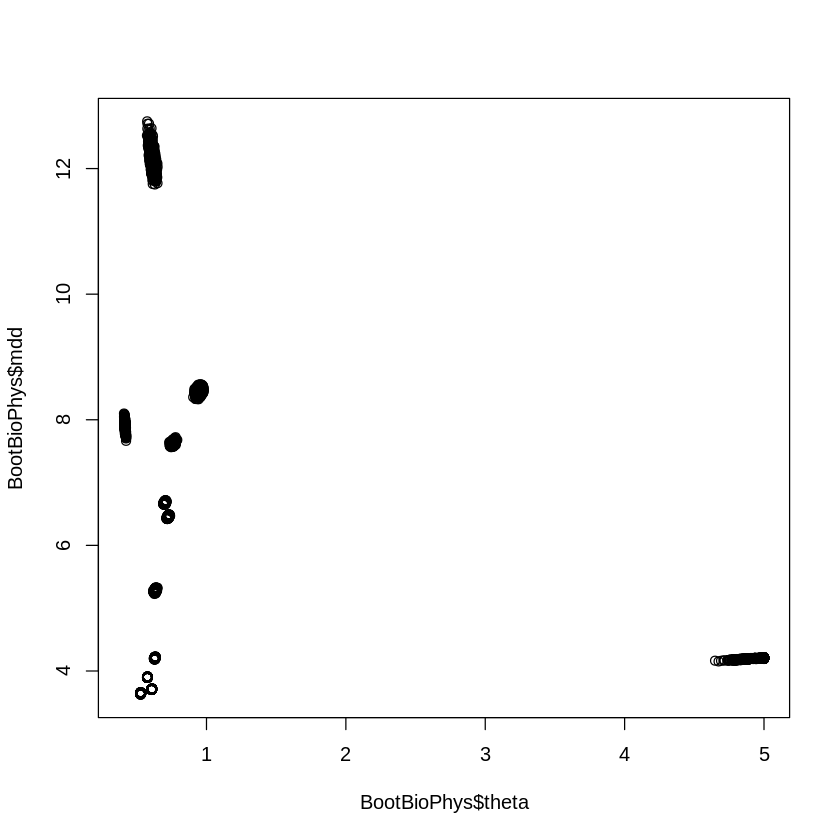

In [66]:
cor.test(BootBioPhys$theta, BootBioPhys$mdd)
plot(BootBioPhys$theta, BootBioPhys$mdd)

In [74]:
ToPlotVariation <- melt(MLEVariation, id.vars=c("data_source","time_scale"))
ToPlotBoot <- melt(BootBioPhysCV, id.vars=c("iteration","time_scale", "data_source"))

head(ToPlotVariation)
head(ToPlotBoot)

data_source,time_scale,variable,value
simulation_08PLD,annual,cv_theta,1.24
simulation_08PLD,season,cv_theta,0.26
genetics,annual,cv_theta,0.83
genetics,season,cv_theta,1.22
simulation_08PLD,annual,cv_mdd,0.08
simulation_08PLD,season,cv_mdd,0.51


iteration,time_scale,data_source,variable,value
1,annual,simulation_08PLD,cv_theta,1.244
1,season,simulation_08PLD,cv_theta,0.264
2,annual,simulation_08PLD,cv_theta,1.240
2,season,simulation_08PLD,cv_theta,0.260
3,annual,simulation_08PLD,cv_theta,1.231
3,season,simulation_08PLD,cv_theta,0.269


In [75]:
test <- rbind(ToPlotBoot[, stat := "boot"], ToPlotVariation[,stat := "MLE"], fill=TRUE)
str(test)

Classes ‘data.table’ and 'data.frame':	20020 obs. of  6 variables:
 $ iteration  : int  1 1 2 2 3 3 4 4 5 5 ...
 $ time_scale : chr  "annual" "season" "annual" "season" ...
 $ data_source: chr  "simulation_08PLD" "simulation_08PLD" "simulation_08PLD" "simulation_08PLD" ...
 $ variable   : Factor w/ 5 levels "cv_theta","cv_mdd",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ value      : num  1.244 0.264 1.24 0.26 1.231 ...
 $ stat       : chr  "boot" "boot" "boot" "boot" ...
 - attr(*, ".internal.selfref")=<externalptr> 


Warning message:
“Removed 10000 rows containing missing values (stat_boxplot).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 10000 rows containing missing values (stat_boxplot).”

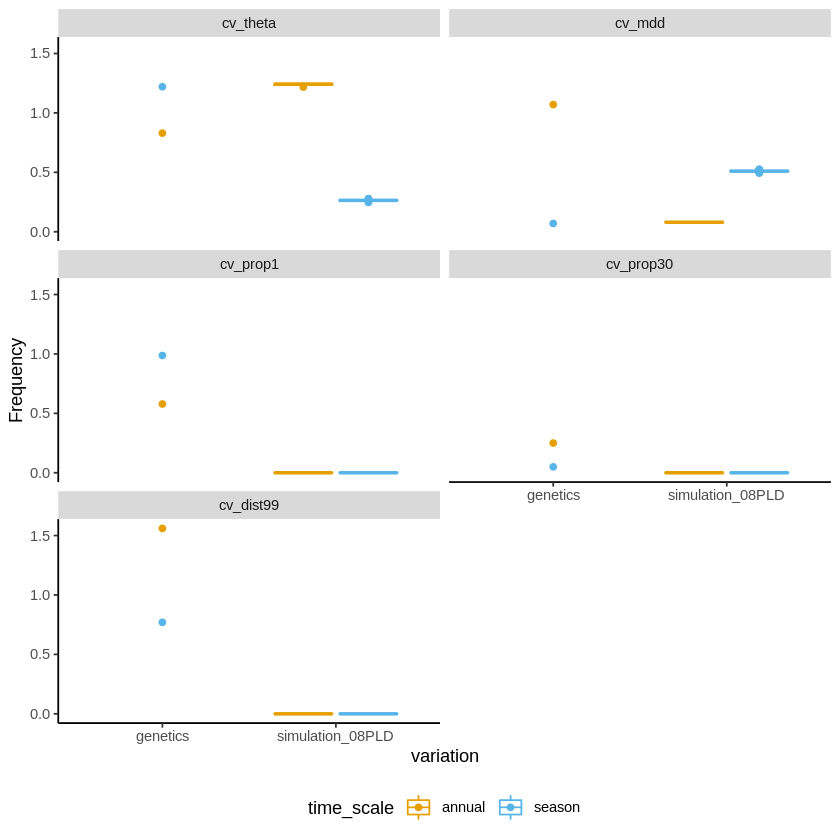

In [78]:
ToPlotVariation$data_source <- factor(ToPlotVariation$data_source, levels=c("genetics", "simulation_08PLD"))#, "simulation_15PLD"
ToPlotBoot$data_source <- factor(ToPlotBoot$data_source, levels=c("genetics", "simulation_08PLD"))#, "simulation_15PLD"
test$data_source <- factor(test$data_source, levels=c("genetics", "simulation_08PLD"))#, "simulation_15PLD"

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

CVPlotAnnual <- ggplot(data=test[ data_source != "simulation_15PLD"], aes(x=data_source , y=value, color=time_scale) ) +
    geom_boxplot(data=test[stat== "boot"]) +#aes(x=data_source, y=value, color=time_scale)#, binwidth = 0.005
    #geom_histogram(data=ToPlotBoot[variable !="sd_k" & time_scale=="annual"& data_source=="simulation_15PLD"], aes(x=value), color="#CC79A7", fill="#CC79A7", binwidth = 0.005) +
    geom_point(data=test[stat== "MLE" & data_source =="genetics"]) + #, aes(x=data_source, y=value,  color=time_scale)
    ylab("Frequency") +
    xlab("variation")+
    theme(legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"))+
    scale_colour_manual(values=cbbPalette)+
    scale_fill_manual(values=cbbPalette)+
    facet_wrap(~  variable, ncol = 2) 

   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlotAnnual

#ggsave(filename="BootstrappedCVComparisonBothTimeScales5Panel.png", plot= CVPlotAnnual, path="~/oceanography/script_output/plots/" )


In [122]:
KernelFittingSummary

data_source,time_scale,time_id,lower_k,k,upper_k,lower_theta,theta,upper_theta,lower_mdd,mdd,upper_mdd,lower_med,med,upper_med,lower_dist90,dist90,upper_dist90,kurtosis
simulation_08PLD,annual,2012,-2.167,-2.164,-2.162,4.980,4.991,4.995,4.20,4.21,4.22,4.00,4.01,4.02,7.86,7.88,7.90,-0.9291035
simulation_08PLD,annual,2013,-0.463,-0.461,-0.459,0.629,0.630,0.630,4.19,4.21,4.23,2.31,2.32,2.33,10.34,10.38,10.43,10.8966730
simulation_08PLD,annual,2014,0.280,0.283,0.285,0.527,0.528,0.528,3.63,3.65,3.67,1.77,1.78,1.79,9.10,9.16,9.22,18.6209801
simulation_08PLD,interannual,2012-4,-0.105,-0.104,-0.103,0.576,0.576,0.576,3.90,3.90,3.91,2.03,2.03,2.03,9.72,9.72,9.74,14.2183515
simulation_08PLD,season,NEM,-0.226,-0.225,-0.225,0.607,0.607,0.608,3.70,3.71,3.72,1.99,2.00,2.00,9.15,9.19,9.21,12.1534414
simulation_08PLD,season,SWM,0.601,0.602,0.605,0.416,0.416,0.417,7.81,7.89,7.94,3.14,3.17,3.19,19.82,20.02,20.17,42.1974355
simulation_15PLD,annual,2012,-2.055,-2.051,-2.048,0.942,0.946,0.949,8.38,8.45,8.54,5.69,5.73,5.78,19.46,19.64,19.85,3.5060575
simulation_15PLD,annual,2013,-1.543,-1.539,-1.533,0.759,0.760,0.760,7.58,7.63,7.68,4.64,4.67,4.70,18.22,18.34,18.46,6.4105542
simulation_15PLD,annual,2014,-0.703,-0.698,-0.694,0.632,0.632,0.632,5.25,5.28,5.30,2.90,2.91,2.93,12.95,13.02,13.07,10.7965955
simulation_15PLD,interannual,2012-4,-1.219,-1.216,-1.214,0.701,0.701,0.701,6.66,6.68,6.70,3.91,3.92,3.93,16.21,16.25,16.29,8.0297830


Saving 6.67 x 6.67 in image


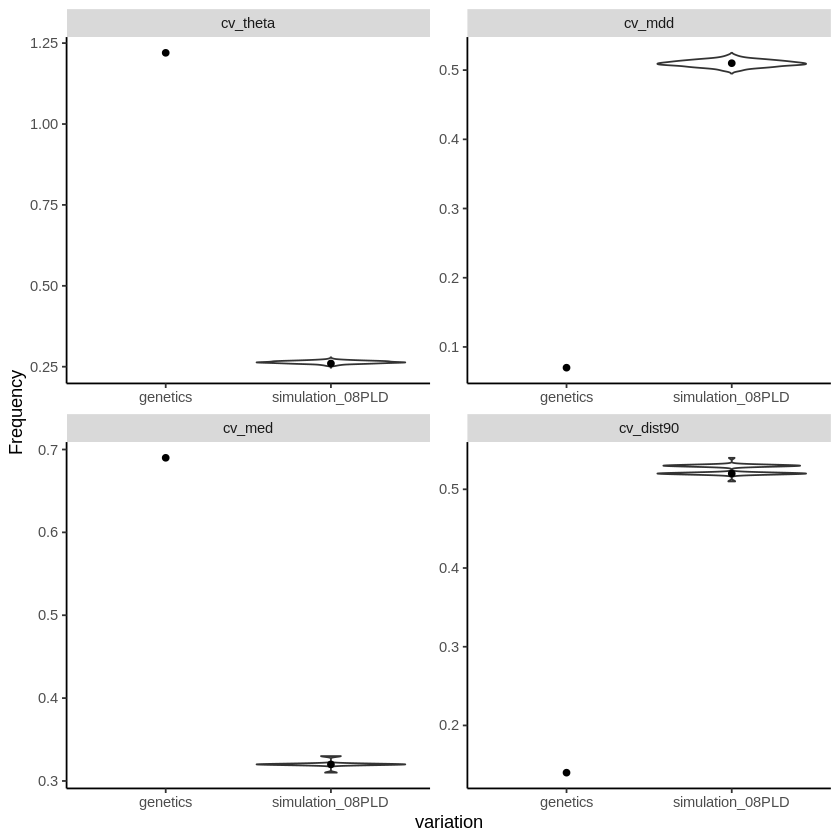

In [124]:
ToPlotVariation$data_source <- factor(ToPlotVariation$data_source, levels=c("genetics", "simulation_08PLD", "simulation_15PLD"))

cbbPalette <- c("#E69F00", "#56B4E9", "#CC79A7")#, #"#F0E442","#009E73" "#0072B2", "#D55E00", "#CC79A7")

CVPlotMonsoon <- ggplot() +
    geom_violin(data=ToPlotBoot[variable !="sd_k" & time_scale=="season"& data_source != "simulation_15PLD"], aes(x=data_source, y=value)) +#, binwidth = 0.005
    #geom_histogram(data=ToPlotBoot[variable !="sd_k" & time_scale=="annual"& data_source=="simulation_15PLD"], aes(x=value), color="#CC79A7", fill="#CC79A7", binwidth = 0.005) +
    geom_point(data=ToPlotVariation[variable !="sd_k"& variable != "sd_kurtosis" &time_scale=="season"& data_source != "simulation_15PLD"], aes(x=data_source, y=value)) +
    ylab("Frequency") +
    xlab("variation")+
    theme(legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"))+
    scale_colour_manual(values=cbbPalette)+
    scale_fill_manual(values=cbbPalette)+
    facet_wrap(~  variable, ncol = 2, scales = "free") 

   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlotMonsoon

#ggsave(filename="BootstrappedCVComparisonMonsoon.png", plot= CVPlotMonsoon, path="~/oceanography/script_output/plots/" )

In [105]:
#relationship with enso?
#annual&monsoon fits and 2011 as well
#define monsoon months
NEM <- c(11, 12, 1, 2, 3, 4, 5, 6)
SWM <- c(7, 8, 9, 10)
#load data
AnnualMonsoonKernels <- fread(file="~/oceanography/script_output/KernelFits/summary_tables/SimulationKernelFitsAnnualMonsoon08DayPLD.csv")
enso <- fread(file="~/oceanography/empirical_data/environment/enso/meiv2.csv")
#setnames(enso, "YEAR", "year")
setnames(enso, c("YEAR","DJ", "JF", "FM", "MA", "AM", "MJ", "JJ", "JA", "AS", "SO", "ON", "ND"), c("year","12,1", "1,2", "2,3", "3,4", "4,5", "5,6", "6,7", "7,8", "8,9", "9,10", "10,11", "11,12"))
#reshape to join
ENSO <- melt(enso, id.vars="year", variable.name = "month_window", value="mei_index")[, `:=`(year=as.numeric(year), month_window=as.character(month_window))][
    year %in% c(2010,2011, 2012, 2013, 2014)][
    , paste0("month", 1:2) := tstrsplit(month_window, ",")]#split the month window column so each month/year combo has a row 

ENSOMonthly <- unique(melt(ENSO[,-"month_window"], id.vars=c("year", "mei_index"), value.name="month")[,-"variable"][#reshape so each month/year combo has a row
    , month := as.numeric(month)][ # to match list of monsoon months
    , monsoon := ifelse(month %in% NEM, "NEM", "SWM")][ #use unique because each month has 2 measurements of mei because it's measured in two month windows. just take the first value so it's consistent
    , year_sampled := ifelse(month %in% SWM, year+1, ifelse(month %in% c(11,12), year+1, year))][ #to match the way we divided years, if there is a SWM fit, it's the data from the year preceding it's "year_sampled" based on our field season timing. If it's the NEM months, then it is a part of the NEM  year that season ends, so a NEM month in 2012 could be any month before June in 2012 but also any month after October in 2011 
    , time_id := paste0(monsoon, year_sampled)][#make a time_id column to join with annual monsoon summary table
    , month_avg_mei_index := mean(mei_index), by=c("month", "year")][
    , annual_monsoon_avg_mei := mean(month_avg_mei_index), by=c("time_id")], by="time_id")

#join kernels and ENSO data together
AnnualMonsoonENSO <- left_join(AnnualMonsoonKernels, ENSOMonthly, by="time_id")

In [106]:
AnnualMonsoonENSO 

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source,year,mei_index,month,monsoon,year_sampled,month_avg_mei_index,annual_monsoon_avg_mei
annual_monsoon,NEM2011,-1.75309,1.30265,4.262,3.24,9.39,-1045881.8,simulation_08PLD,2010,0.93,12,NEM,2011,-0.490,-1.417500
annual_monsoon,NEM2012,-1.73326,1.26304,4.300,3.24,9.52,-1120211.9,simulation_08PLD,2011,-1.83,12,NEM,2012,-1.535,-0.683750
annual_monsoon,NEM2013,-1.85889,1.35246,4.584,3.52,10.04,-1028977.7,simulation_08PLD,2012,-1.08,12,NEM,2013,-0.575,-0.445625
annual_monsoon,NEM2014,-1.50649,1.11461,3.917,2.83,8.86,-901086.4,simulation_08PLD,2013,-0.05,12,NEM,2014,-0.200,-0.177500
annual_monsoon,SWM2011,-2.14126,1.60872,5.359,4.31,11.41,-371065.6,simulation_08PLD,2010,-2.40,7,SWM,2011,-2.415,-2.273750
annual_monsoon,SWM2012,-1.92231,1.47343,4.566,3.59,9.86,-141712.1,simulation_08PLD,2011,-0.88,7,SWM,2012,-0.870,-1.111250
annual_monsoon,SWM2013,-1.92912,1.40630,4.763,3.70,10.37,-195363.6,simulation_08PLD,2012,-0.06,7,SWM,2013,0.120,-0.121250
annual_monsoon,SWM2014,-2.08679,1.56256,5.170,4.13,11.06,-197547.8,simulation_08PLD,2013,-0.50,7,SWM,2014,-0.675,-0.388750



Call:
lm(formula = mdd ~ annual_monsoon_avg_mei + monsoon, data = AnnualMonsoonENSO)

Residuals:
       1        2        3        4        5        6        7        8 
-0.12705  0.03381  0.35767 -0.26443  0.17684 -0.42152 -0.05877  0.30345 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              4.1517     0.1982  20.952 4.59e-06 ***
annual_monsoon_avg_mei  -0.1674     0.1692  -0.989   0.3679    
monsoonSWM               0.6498     0.2333   2.785   0.0387 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3224 on 5 degrees of freedom
Multiple R-squared:  0.6748,	Adjusted R-squared:  0.5447 
F-statistic: 5.188 on 2 and 5 DF,  p-value: 0.06031


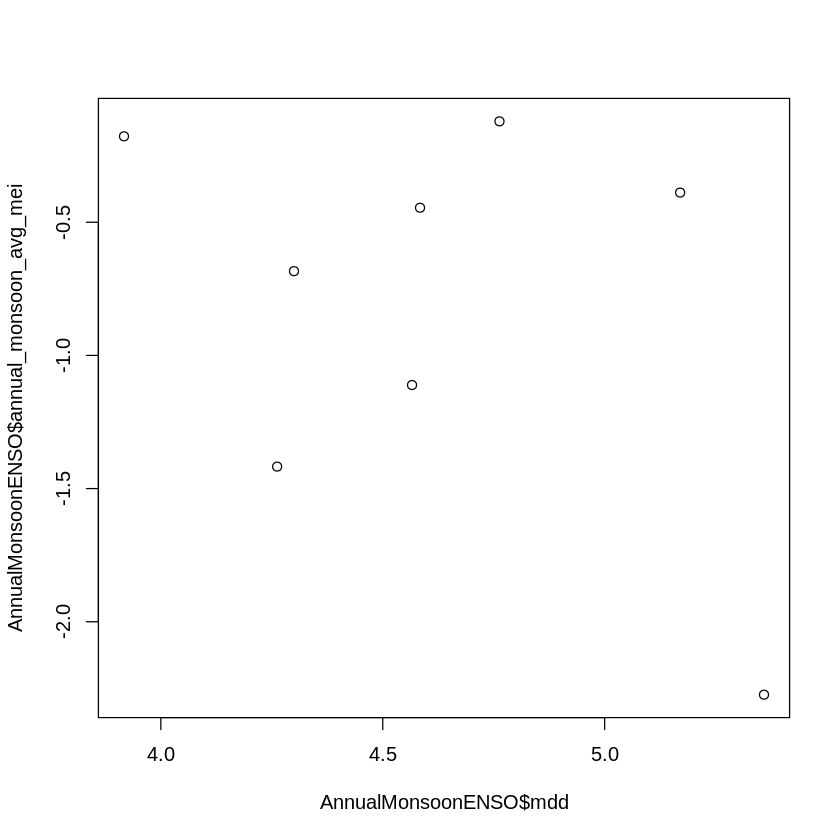

In [107]:

plot(AnnualMonsoonENSO$mdd, AnnualMonsoonENSO$annual_monsoon_avg_mei)
test_mod <- lm(data=AnnualMonsoonENSO, mdd ~ annual_monsoon_avg_mei+ monsoon)
summary(test_mod)

Saving 6.67 x 6.67 in image


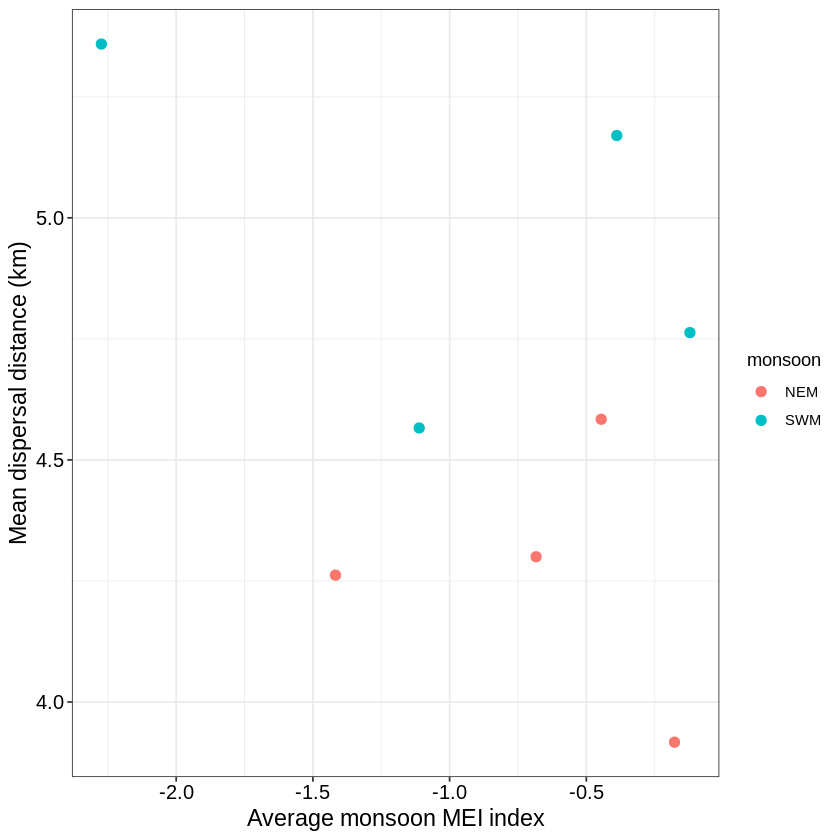

In [116]:
MonsoonKernelsENSO <- ggplot() +
    geom_point(data=AnnualMonsoonENSO, aes(x=annual_monsoon_avg_mei, y=mdd, color=monsoon), size=2.5) +
    theme_bw()+
    theme(axis.text.x = element_text(size=12, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=14, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=14, color="black", family="Helvetica")) +
    ylab("Mean dispersal distance (km)")+
    xlab("Average monsoon MEI index")
MonsoonKernelsENSO
#ggsave(filename="MonsoonKernelsENSO.png",  plot=MonsoonKernelsENSO, path="~/oceanography/script_output/plots/", units="in")


In [119]:
ENSOMonthly

year,mei_index,month,monsoon,year_sampled,time_id,month_avg_mei_index,annual_monsoon_avg_mei
2010,0.93,12,NEM,2011,NEM2011,-0.490,-1.4175000
2011,-1.83,12,NEM,2012,NEM2012,-1.535,-0.6837500
2012,-1.08,12,NEM,2013,NEM2013,-0.575,-0.4456250
2013,-0.05,12,NEM,2014,NEM2014,-0.200,-0.1775000
2014,-0.51,12,NEM,2015,NEM2015,-0.085,0.1275000
2010,1.28,1,NEM,2010,NEM2010,1.105,0.1383333
2010,-2.40,7,SWM,2011,SWM2011,-2.415,-2.2737500
2011,-0.88,7,SWM,2012,SWM2012,-0.870,-1.1112500
2012,-0.06,7,SWM,2013,SWM2013,0.120,-0.1212500
2013,-0.50,7,SWM,2014,SWM2014,-0.675,-0.3887500


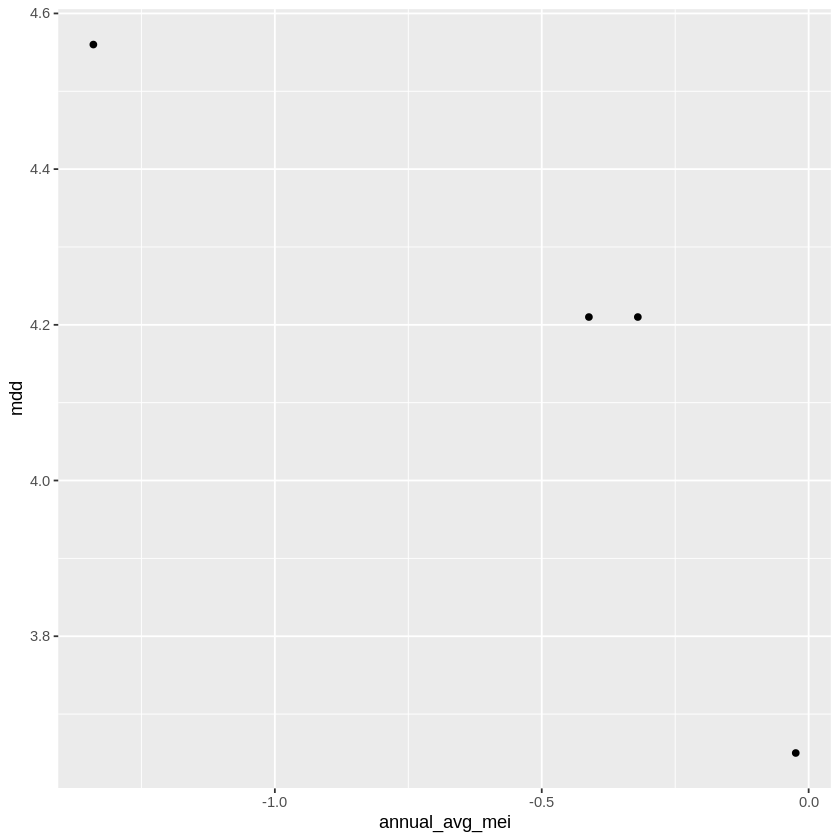

In [185]:
ggplot() +
    geom_point(data=AnnualKernelsENSO[data_source=="simulation"], aes(x=annual_avg_mei, y=mdd))